In [1]:
import alminer, pandas, pymysql, time, glob, os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def build_tmp_table(ra, dec, search_radius_arcmin):
    
    # construct a temporary table from template

    template_file = 'template_tap.txt'
    path_to_template = '/arc/projects/salvage/ALMAxmatch/notebooks/'

    table_file = 'sdss_positions_tap.txt'
    path_to_file = '/arc/projects/salvage/ALMAxmatch/notebooks/'

    os.system(f'cp {path_to_template + template_file} {path_to_file + table_file}')

    # get template table (formatting with no coordinates)
    out = open(path_to_file + table_file, 'r')
    out_data = out.read()
    out.close()

    search_radius_deg = search_radius_arcmin/60

    # initialize string
    coords_str = ''

    # format the ra and dec's for html table
    for r, d in zip(ra, dec):

        coords_str += "          <TR>\n" 
        coords_str += f"            <TD>{r}</TD>\n"
        coords_str += f"            <TD>{d}</TD>\n"
        coords_str += "          </TR>\n"
        coords_str += "\n"

    # replace __COORDS__ in template with formatted coords
    out_data = out_data.replace('          __COORDS__', coords_str)

    # write to new table
    out = open(path_to_file + table_file, 'w')
    out.write(out_data)
    out.close()
    
    return table_file, path_to_file

def generate_query(ra, dec, search_radius_arcmin = 0.5):
    
    # generate a custom ALminer query from a list of known hits

    query_str = "SELECT * FROM ivoa.ObsCore WHERE data_rights LIKE '%Public%' AND ("

    search_radius_deg = search_radius_arcmin/60

    initialized = False

    for r, d in zip(ra, dec):

        if not initialized:

            query_str += f"1 = INTERSECTS(CIRCLE('ICRS',{r}, {d}, {search_radius_deg}), s_region) " 
            initialized = True

        else: 

            query_str += f"OR 1 = INTERSECTS(CIRCLE('ICRS',{r}, {d}, {search_radius_deg}), s_region) " 

        query_str += f"OR 1 = CONTAINS(POINT('ICRS',{r},{d}), s_region) "

    query_str += ')'
    
    return query_str

In [34]:
#Query MySQL for SDSS positions
db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'sdss', user = 'swilkinson', passwd = '123Sdss!@#')
x = 'SELECT u.objID, u.ra, u.decl, u.total_mass_med, u.z_spec, u.petroR50_r FROM  dr7_uberuber u WHERE u.total_mass_med > 1 AND u.z_spec < 0.5 AND u.decl < 47'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()
	
# transpose queried table
data = np.array(db_data, dtype = float).T
table_id = np.array(db_data, dtype = str).T[0]

In [35]:
ra_sdss = data[1]
dec_sdss = data[2]
mass_sdss = data[3]
z_sdss = data[4]
rpetro_sdss = data[5]

(array([337., 707., 865., 668., 573., 347., 322., 180., 131., 252., 111.,
         64., 100.,  78.,  24.,  13.,  21.,  64., 101.,   0.,  20.,  30.,
         20.,  24.,   4.,  16.,   0.,   0.,   8.,   4.,   0.,   0.,   0.,
        134.,   0.,  12.,  12.,   0.,  20.,   0.,   0.,   0.,   0.,   0.,
         12.,   0.,   0.,   0.,   4.,  12.]),
 array([ 1.26417298,  2.13819918,  3.01222538,  3.88625159,  4.76027779,
         5.634304  ,  6.5083302 ,  7.38235641,  8.25638261,  9.13040882,
        10.00443502, 10.87846123, 11.75248743, 12.62651363, 13.50053984,
        14.37456604, 15.24859225, 16.12261845, 16.99664466, 17.87067086,
        18.74469707, 19.61872327, 20.49274947, 21.36677568, 22.24080188,
        23.11482809, 23.98885429, 24.8628805 , 25.7369067 , 26.61093291,
        27.48495911, 28.35898531, 29.23301152, 30.10703772, 30.98106393,
        31.85509013, 32.72911634, 33.60314254, 34.47716875, 35.35119495,
        36.22522116, 37.09924736, 37.97327356, 38.84729977, 39.72132597,
 

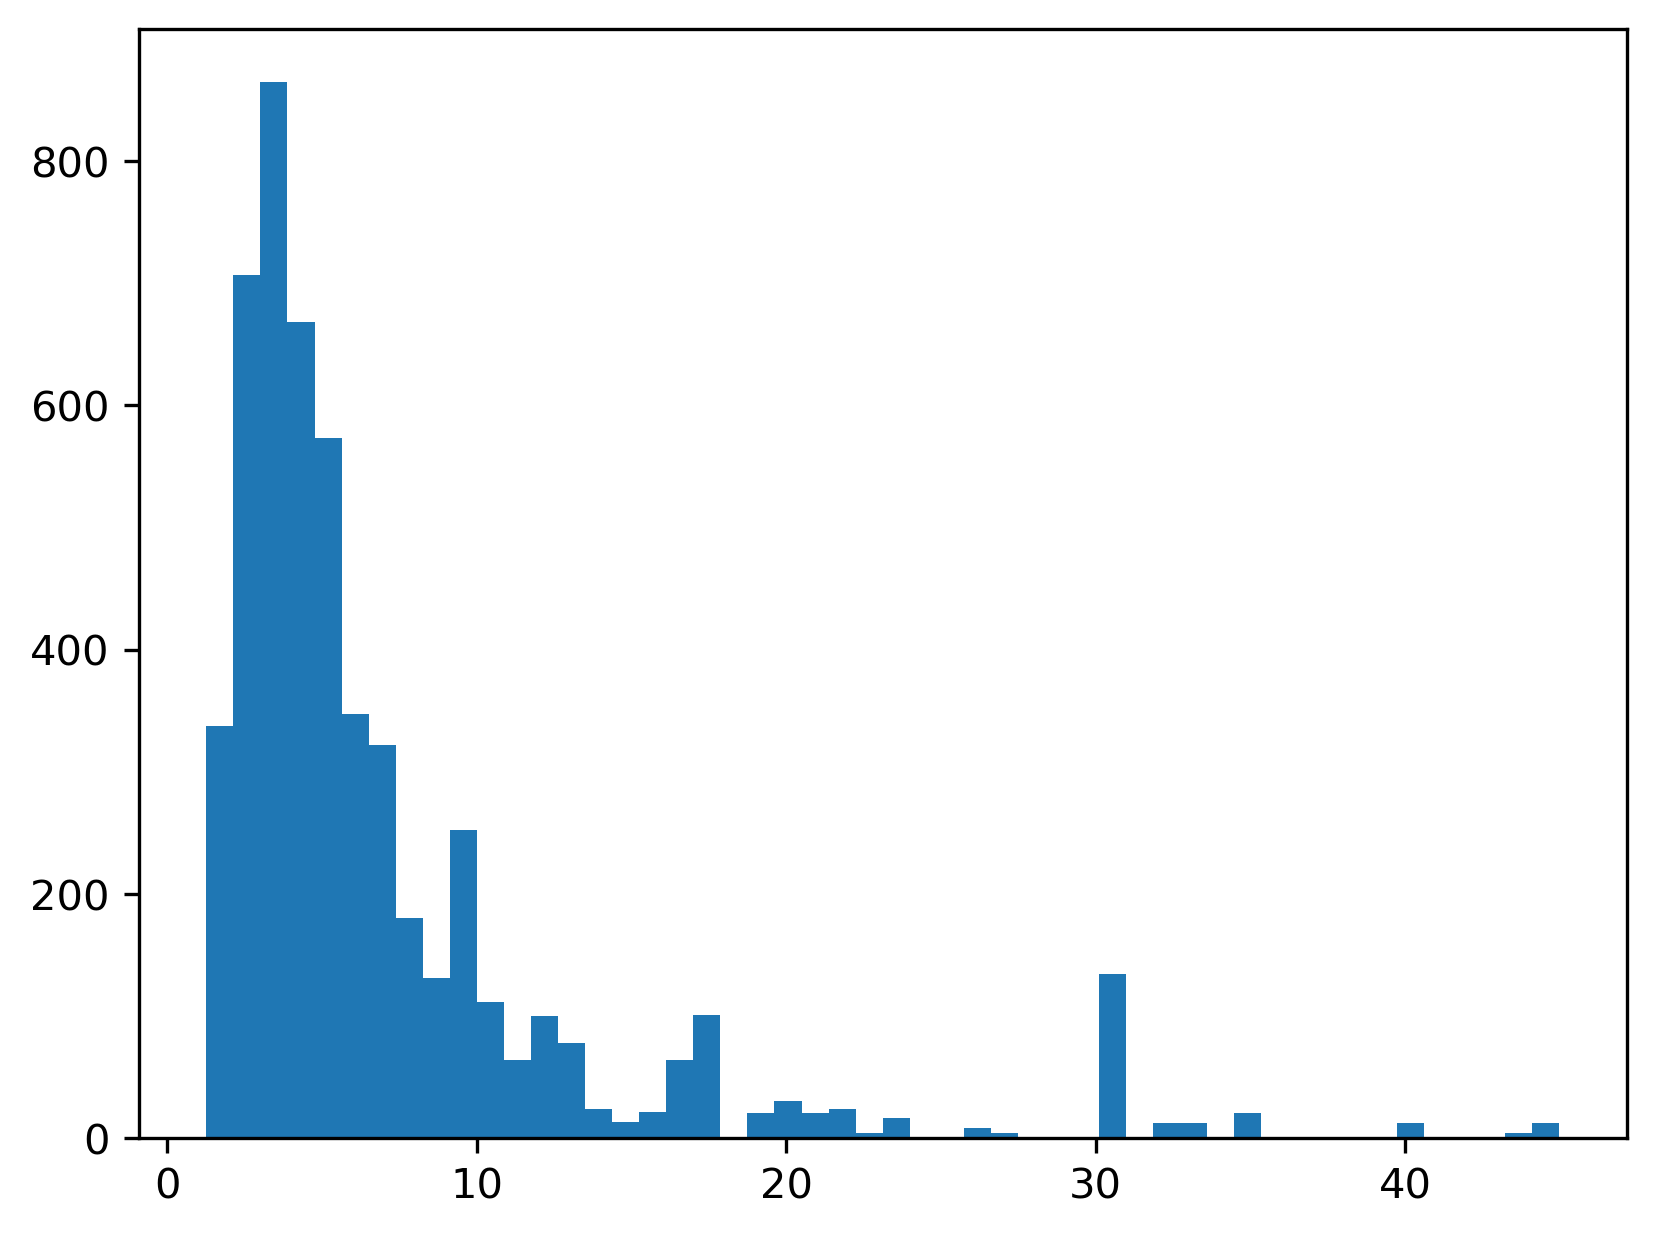

In [47]:
plt.hist(4*rpetro_query*0.396, bins = 50)

In [14]:
len(ra_sdss)

568753

In [6]:
# split up targets into separate jobs (nJobs)
nJobs = 300

# number of targets in each job
N = int(np.ceil(len(ra_sdss)/nJobs))
print(N)

# number of completed jobs to start from
completed = 0

# search radius of query
search_radius_arcmin = 0.167 # 10 arcsec
search_radius_deg = search_radius_arcmin/60

# run query jobs in serial    
for i in np.arange(completed, nJobs, 1):
    
    ## splitting up targets into manageable subset
    if i == nJobs-1:
    
        ra_table = ra_sdss[i*N:]
        dec_table = dec_sdss[i*N:]
        
    else:
    
        ra_table = ra_sdss[i*N:(i+1)*N]
        dec_table = dec_sdss[i*N:(i+1)*N]
        
    ###### query ALMA archive to match subset with a temporary HTML table and cadc-tap #######
        
    ## create temporary table with target subset    
    table_file, path_to_table = build_tmp_table(ra_table, dec_table, search_radius_arcmin = search_radius_arcmin)
    
    output_file = 'sdss_x_alma_positions.txt'
    path_to_output = '/arc/projects/salvage/ALMAxmatch/notebooks/'

    # wipe old output file
    tmp = open(path_to_output+output_file, 'w')
    tmp.close()
    
    ## query with cadc-tap
    start = time.time()
    os.system(f'cadc-tap query -s https://almascience.nao.ac.jp/tap --tmptable mytable:{path_to_table + table_file} \
            "SELECT DISTINCT oc.s_ra, oc.s_dec FROM ivoa.obscore oc JOIN tap_upload.mytable t \
            ON 1 = INTERSECTS(CIRCLE(\'ICRS\', t.s_ra, t.s_dec, {search_radius_deg}), oc.s_region) AND oc.data_rights LIKE \'%Public%\'"\
            > {path_to_output + output_file}')
    end = time.time()
    print(f'Querying {N} galaxies took {(end-start)/60} min.')
    
    ########################################################################################
    
    ################## convert results to an ALminer query object ##########################
    
    # remove last two lines of the text file

    out = open(path_to_output + output_file, 'r')
    lines = out.readlines()
    out.close()

    lines = lines[:-2]

    out = open(path_to_output + output_file, 'w')
    out.write(''.join(lines))
    out.close()
    
    if len(lines) < 3:
        print('No matches!')
        continue
    
    # collect ra and dec of all sub-band ra-dec
    ra_match, dec_match = np.loadtxt(path_to_output + output_file, unpack = True, skiprows = 2)
    
    #print(type(ra_match), type(dec_match))
    
    if type(ra_match) == np.float64:
        ra_match_unique = np.array([ra_match])
        dec_match_unique = np.array([dec_match])
        
    else:

        # generate strings of ra_dec pairs to identify unique targets
        rd_str = np.array([f'{r}_{d}' for r, d in zip(ra_match, dec_match)])

        # identify unique targets from xmatch output
        rd_str_unique, index_unique = np.unique(rd_str, return_index = True)
        ra_match_unique = ra_match[index_unique]
        dec_match_unique = dec_match[index_unique]
    
    # generate a custom ALminer query from xmatch hits
    query_str = generate_query(ra_match_unique, dec_match_unique, search_radius_arcmin = search_radius_arcmin)
    
    start = time.time()
    myquery = alminer.run_query(query_str)
    myquery = alminer.filter_results(myquery)
    end = time.time()
    print(f'This query took {(end-start)/60} min.')

    # if there are observations found, print out summary and save for later
    if myquery is None:
        print('No observations found in query.')
    else:
        
        # print out summary
        #alminer.summary(myquery)
        
        # pickle data for later
        myquery.to_pickle(f'/arc/projects/salvage/ALMAxmatch/ALminer_output/SDSS-ALMA-search-Jan15-Job{i}.pkl')
        
        
    ########################################################################################


1896
Querying 1896 galaxies took 0.4989825367927551 min.
--------------------------------
Number of projects = 4
Number of observations = 4
Number of unique subbands = 16
Total number of subbands = 16
4 target(s) with ALMA data = ['HATLASJ121253.5-002203', 'SDSS_J152224.73-004404.5', 'HATLASJ121253', '105386']
--------------------------------
This query took 0.04563245375951131 min.
Querying 1896 galaxies took 0.2881238142649333 min.
--------------------------------
Number of projects = 7
Number of observations = 17
Number of unique subbands = 60
Total number of subbands = 68
11 target(s) with ALMA data = ['HATLAS_J143336.7+005042', 'HATLAS_J140608.2+005501', 'UR7G', '1237648705664450617', '1237648704051675158', 'HATLAS_RED_2221', 'GAMA106389', 'HATLAS1744', 'HATLAS1745', 'HATLAS1114', 'GAMA64646']
--------------------------------
This query took 0.05359952052434285 min.
Querying 1896 galaxies took 0.3656751354535421 min.
--------------------------------
Number of projects = 3
Number o

ERROR:: <!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">
<html><head>
<title>502 Proxy Error</title>
</head><body>
<h1>Proxy Error</h1>
<p>The proxy server received an invalid
response from an upstream server.<br />
The proxy server could not handle the request <em><a href="/tap/sync/is3yu1yv129j4fgt/run">GET&nbsp;/tap/sync/is3yu1yv129j4fgt/run</a></em>.<p>
Reason: <strong>Error reading from remote server</strong></p></p>
</body></html>



Querying 1896 galaxies took 0.03509366512298584 min.
No matches!
Querying 1896 galaxies took 0.15036361217498778 min.
No matches!
Querying 1896 galaxies took 0.18197716474533082 min.
--------------------------------
Number of projects = 1
Number of observations = 1
Number of unique subbands = 4
Total number of subbands = 4
1 target(s) with ALMA data = ['127995']
--------------------------------
This query took 0.026871760686238606 min.
Querying 1896 galaxies took 0.17491822242736815 min.
--------------------------------
Number of projects = 1
Number of observations = 1
Number of unique subbands = 4
Total number of subbands = 4
1 target(s) with ALMA data = ['224444']
--------------------------------
This query took 0.021391916275024413 min.
Querying 1896 galaxies took 0.16620837847391765 min.
No matches!
Querying 1896 galaxies took 0.18313289880752565 min.
--------------------------------
Number of projects = 1
Number of observations = 2
Number of unique subbands = 4
Total number of sub

ERROR:: <!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">
<html><head>
<title>502 Proxy Error</title>
</head><body>
<h1>Proxy Error</h1>
<p>The proxy server received an invalid
response from an upstream server.<br />
The proxy server could not handle the request <em><a href="/tap/sync">POST&nbsp;/tap/sync</a></em>.<p>
Reason: <strong>Error reading from remote server</strong></p></p>
</body></html>



Querying 1896 galaxies took 0.02217682997385661 min.
No matches!
Querying 1896 galaxies took 0.174170450369517 min.
--------------------------------
Number of projects = 1
Number of observations = 1
Number of unique subbands = 4
Total number of subbands = 4
1 target(s) with ALMA data = ['242308']
--------------------------------
This query took 0.02290194034576416 min.
Querying 1896 galaxies took 0.17780445019404092 min.
--------------------------------
Number of projects = 1
Number of observations = 4
Number of unique subbands = 12
Total number of subbands = 16
4 target(s) with ALMA data = ['578499', '66351', '304615', '654650']
--------------------------------
This query took 0.027136091391245523 min.
Querying 1896 galaxies took 0.18830944299697877 min.
--------------------------------
Number of projects = 1
Number of observations = 3
Number of unique subbands = 12
Total number of subbands = 12
3 target(s) with ALMA data = ['640213', '67202', '609961']
-------------------------------

In [8]:
# concatenate queries from Jobs

files = glob.glob('/arc/projects/salvage/ALMAxmatch/ALminer_output/*Jan15*')

myquery_list = []
for f in tqdm(files):
    myquery_list.append(pandas.read_pickle(f))
    
myquery = pandas.concat(myquery_list)

myquery.to_pickle(f'/arc/projects/salvage/ALMAxmatch/ALminer_output/SDSS-ALMA-search-Jan15-total.pkl')

100%|██████████| 197/197 [00:15<00:00, 12.78it/s]


In [9]:
alminer.summary(myquery)

--------------------------------
Number of projects = 349
Number of observations = 1355
Number of unique subbands = 3221
Total number of subbands = 5290
790 target(s) with ALMA data = ['AT2018hyz', 'AS2COS0157.1', 'XrayOpt_TDE1_ASASSN-18z', 'COS850.0157', 'Q09498+0155', 'J1313', 'HATLAS_J090034.2+011856', 'HOT2_EI_CII_G09.v2.137', 'HATLAS_J084552.0+011121', 'HOT2_EI_CII_G09.v2.167', 'GEMS-N4636-18', 'UGC07824', 'G09.v2.167', 'Ceres', 'G09.v2.137', 'NGC_4254', '1994018546606172160', '656018', '437037', '577834', 'ngc4254_enuc001', 'ngc4254', 'DDO_155', '127995', 'NGC_4922', 'PGC57475', 'HATLAS_RED_1770', 'HATLAS_RED_2150', 'Mrk_463', 'AGC_9727', 'J1518+1403', '474401', 'IC_485', '8941-3701', 'C_488', '1237654030328791126', '2993', '410490', 'Alpine_2', 'HATLASJ091956.9+013852', '13J090238.7+013253', 'DEIMOS_COSMOS_460378', '12J090234.3+012518', 'HATLAS_J092131.0+013432', 'lowz_cell8_108065', 'AzTECC43', 'J100217.9+015124', 'AzTECC51', 'HATLASJ091956', 'AGC191728', 'HATLAS_J145013.2+0121

In [8]:
alminer.summary(myquery)

--------------------------------
Number of projects = 344
Number of observations = 1333
Number of unique subbands = 3170
Total number of subbands = 10392
783 target(s) with ALMA data = ['RFGC2966', 'HATLAS_RED_2145', 'J1016+0028', 'Mrk_463', 'J1518+1403', 'AGC_9727', '588015510364880957_8082-6103', 'SDSS_074755.45+192910.5', '8149-12704', 'CIG_268', 'R05', 'CP_8241_12705', 'ADF22', '587731511545626673_8081-3704', '8077-9101', '587731511545233578_8082-12701', '587731187797393472_8615-3703', 'NBJ-CFHT-C343', 'mADF22', 'Core_region', 'UGC01123', '8086-9101', 'PM2_8153_12702', 'CP_7968_12705', 'dm0052+00_I116', 'dm0052+00_I115', 'DSFG4', 'RXCJ2341.1+0018', 'IRAS_15250+3609', 'SDSS_164922.21+264710.5', '624421', 'AGC_5737', '29955', 'IRAS_10190+1322', 'IRAS_F10190+1322', 'HATLAS_J144244.2+015846', 'HATLAS_J141235.5+023130', 'HATLAS_J145019.0+015206', '1237651736305402018', 'rs0680', 'rs0677', 'rs0679', 'IRAS12112+0305', 'IRAS_F12112+0305', 'APEX_SB14', 'irasf12112+0305', 'Q14286+0210', 'IRA

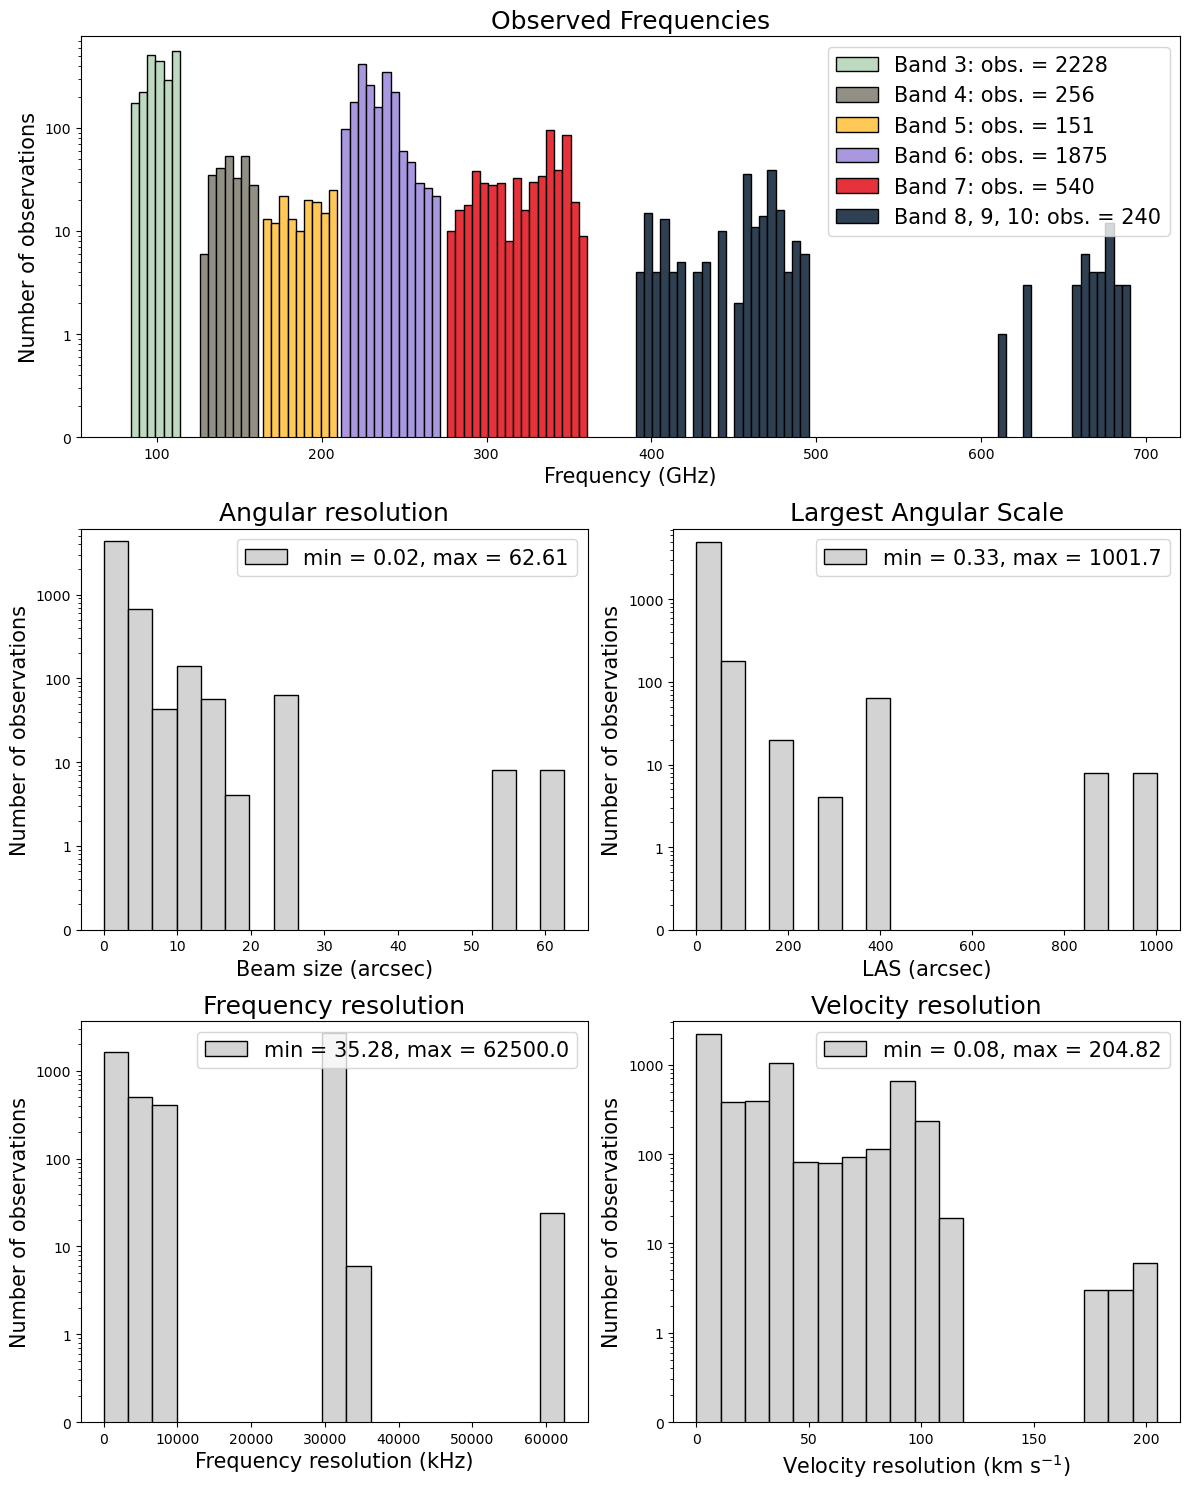

In [10]:
alminer.plot_overview(myquery)

## Match myquery catalog back to SDSS RA/Dec to get redshifts for each observation

In [36]:
ra_query, dec_query = np.array(myquery['RAJ2000']), np.array(myquery['DEJ2000'])

In [37]:
objID_query = []
z_query = []
mass_query = []
rpetro_query = []

for ra_q, dec_q in zip(ra_query, dec_query):
    
    diff = np.sqrt((ra_sdss-ra_q)**2 + (dec_sdss-dec_q)**2)
    
    if np.min(diff) > 30:
        print('Poor match!')
    
    objID_query.append(table_id[diff == np.min(diff)][0])
    z_query.append(z_sdss[diff == np.min(diff)][0])
    mass_query.append(mass_sdss[diff == np.min(diff)][0])
    rpetro_query.append(rpetro_sdss[diff == np.min(diff)][0])

z_query = np.array(z_query)
mass_query = np.array(mass_query)
rpetro_query = np.array(rpetro_query)

In the future I can replace the spatial_scale_max with an SDSS radius...

In [26]:
len(z_query)

10392

In [12]:
rf_12CO_10 = 115.27120180 #GHz

redshifted_line = rf_12CO_10/(1+z_query)

selected = myquery[(myquery["min_freq_GHz"] < redshifted_line) & 
                   (myquery["max_freq_GHz"] > redshifted_line) & 
                   (myquery["ang_res_arcsec"] < 3) & 
                   (myquery["spatial_scale_max"] > 10) & 
                   (myquery["dataproduct_type"] == 'cube')]
alminer.summary(selected)

--------------------------------
Number of projects = 45
Number of observations = 303
Number of unique subbands = 188
Total number of subbands = 624
294 target(s) with ALMA data = ['RFGC2966', 'AGC_9727', '588015510364880957_8082-6103', '8149-12704', 'CIG_268', 'CP_8241_12705', '587731511545626673_8081-3704', '8077-9101', '587731511545233578_8082-12701', '587731187797393472_8615-3703', '8086-9101', 'PM2_8153_12702', 'CP_7968_12705', '624421', 'AGC_5737', '29955', 'HATLAS_J141235.5+023130', 'HATLAS_J145019.0+015206', 'HATLAS_J144244.2+015846', 'rs0680', 'rs0677', 'rs0679', 'RXCJ1350.3+0940', '587741421099155681_8241-3703', 'PKS0034-01', '8655-12705', '170103', '618039', '189167', '8655-3701', 'HELMS_RED_385', '8623-12702', '8616-1902', '8655-1902', 'WP_8616_9101', '4579', 'RFGC296', 'Q01322-0051', '8080-3704', '8081-9101', 'WP_8085_3704', '587731512617664623_8154-9102', '5511', 'GAMA417678', 'HOT2_EI_CII_G09.v2.232', 'CIG234', '127995', 'COSMOS-1200839', 'COSMOS-0969208', 'COSMOS-119751

In [48]:
rf_12CO_10 = 115.27120180 #GHz

redshifted_line = rf_12CO_10/(1+z_query)

selected = myquery[(myquery["min_freq_GHz"] < redshifted_line) & 
                   (myquery["max_freq_GHz"] > redshifted_line) & 
                   (myquery["ang_res_arcsec"] < 3) & 
                   (myquery["spatial_scale_max"] > 4*rpetro_query*0.396) & 
                   (myquery["dataproduct_type"] == 'cube') &
                   (myquery["data_rights"] == 'Public')]
alminer.summary(selected)

--------------------------------
Number of projects = 54
Number of observations = 317
Number of unique subbands = 197
Total number of subbands = 326
311 target(s) with ALMA data = ['Q09498+0155', 'HATLAS_J090034.2+011856', 'HATLAS_J084552.0+011121', 'HOT2_EI_CII_G09.v2.167', 'HOT2_EI_CII_G09.v2.137', '656018', '437037', '577834', 'DDO_155', '127995', 'AGC_9727', '474401', '8941-3701', '2993', 'HATLASJ091956.9+013852', '13J090238.7+013253', '12J090234.3+012518', 'HATLAS_J092131.0+013432', 'AGC191728', 'HATLAS_J145013.2+012125', 'AGC249559', '122665', '136638', 'GAMA239376', 'CP_9195_9101', 'GAMA417678', 'HOT2_EI_CII_G09.v2.232', '123106', '246603', '14265', 'RXCJ1603.6+1553', 'AGC252580', 'rs0768', 'rs0769', '242308', '5456', 'NGC_4150', 'HATLASJ115317.4-010123', 'HATLASJ121908.7-010159', 'JO204_CO10', '114808', 'PM1_8615_1901', 'PM1_8623_1902', '7964-1902', '587731173842027508_8623-6104', '8615-9101', '8623-6104', '8086-3704', '588015508213989555_8077-6104', '8084-12705', '8155-6101', 

In [1]:
rf_12CO_10 = 115.27120180 #GHz

redshifted_line = rf_12CO_10/(1+z_query)

selected = myquery[(myquery["min_freq_GHz"] < redshifted_line) & 
                   (myquery["max_freq_GHz"] > redshifted_line) & 
                   (myquery["ang_res_arcsec"] < 3) & 
                   (myquery["spatial_scale_max"] > 3*rpetro_query*0.396) & 
                   (myquery["dataproduct_type"] == 'cube') &
                   (myquery["data_rights"] == 'Public')]
alminer.summary(selected)

NameError: name 'z_query' is not defined

In [49]:
rf_12CO_21 = 230.53800000 # 12CO J=2-1
redshifted_line = rf_12CO_21/(1+z_query)

selected = myquery[(myquery["min_freq_GHz"] < redshifted_line) & 
                   (myquery["max_freq_GHz"] > redshifted_line) & 
                   (myquery["ang_res_arcsec"] < 3) & 
                   (myquery["spatial_scale_max"] > 4*rpetro_query*0.396) & 
                   (myquery["dataproduct_type"] == 'cube')]
alminer.summary(selected)


--------------------------------
Number of projects = 11
Number of observations = 44
Number of unique subbands = 42
Total number of subbands = 44
44 target(s) with ALMA data = ['GAMA272990', 'JO204_CO21', 'SDSS_J143029.88+133912.0', 'SDSS_081958.64+262311.3', 'APEX_SB17', 'SDSS_J150904.22+043441.8', '0637_584_52174', 'G_20-2', '2360_167_53728', '0480_580_51989', 'APEX_SB14', '2777_258_54554', 'UM461', 'GAMA177186', 'APEX_SB15', 'APEX_SB11', 'APX_SB2_5', 'APEX_SB31', 'APEX_SB13', 'NGC5248', 'GAMA622429', 'LEDA_3098096', 'GMP3779', 'GMP3271', 'IC4040', 'GMP3071', 'GMP3816', 'JO201_CO21', 'JO201_CO21B', '0379_579_51789', 'KUG1140+202B', 'KUG_1141+204', '2MASX_J11443212+2006238', 'APX_SB2_3', 'J112531.90+290311.3', '2276_444_53712', 'GMP3896', 'LEDA_83707', 'GMP2374', '0570_537_52266', 'NGC_3859', 'KUG1141+200', 'SDSS_212639.87+001830.0', 'G04-1']
--------------------------------


In [50]:
rf_12CO_32 = 345.79598990 # 12CO J=3-2
redshifted_line = rf_12CO_32/(1+z_query)

selected = myquery[(myquery["min_freq_GHz"] < redshifted_line) & 
                   (myquery["max_freq_GHz"] > redshifted_line) & 
                   (myquery["ang_res_arcsec"] < 3) & 
                   (myquery["spatial_scale_max"] > 4*rpetro_query*0.396) & 
                   (myquery["dataproduct_type"] == 'cube')]
alminer.summary(selected)


--------------------------------
Number of projects = 13
Number of observations = 32
Number of unique subbands = 29
Total number of subbands = 34
30 target(s) with ALMA data = ['G09.v2.167', 'G09.v2.137', 'HATLASJ091956', '021348', 'HATLASJ115317', 'HATLASJ121908', 'Teacup_AGN', 'HATLASJ090223', 'G09.v2.55', 'G09.v2.107', 'J1512+0203', 'HATLASJ085616', '210358', 'H02', 'HATLASJ121253', 'G09.v2.26', 'HATLASJ091157', 'HATLASJ142057', 'G09.v2.52', 'G09.v2.42', 'J1516+0015', 'G09.v2.48', '015028', 'G14-1', 'SHOC_391', 'G09.v2.45', 'G08-5', 'G09.v2.77', 'G09.v2.235', 'G04-1']
--------------------------------


In [51]:
rf_13CO_21 = 220.3987 # 13CO J=2-1
redshifted_line = rf_13CO_21/(1+z_query)

selected = myquery[(myquery["min_freq_GHz"] < redshifted_line) & 
                   (myquery["max_freq_GHz"] > redshifted_line) & 
                   (myquery["ang_res_arcsec"] < 3) & 
                   (myquery["spatial_scale_max"] > 4*rpetro_query*0.396) & 
                   ((myquery["scientific_category"] == 'Galaxy evolution') | 
                    (myquery["scientific_category"] == 'Active galaxies') |
                    (myquery["scientific_category"] == 'Cosmology') |
                    (myquery["scientific_category"] == 'Local Universe')) &
                   (myquery["dataproduct_type"] == 'cube')]
alminer.summary(selected)

--------------------------------
Number of projects = 2
Number of observations = 2
Number of unique subbands = 2
Total number of subbands = 2
2 target(s) with ALMA data = ['APEX_SB14', 'IRAS_10190+1322']
--------------------------------


In [52]:
rf_CI_10 = 492.1607 # [CI] P=1-0
redshifted_line = rf_CI_10/(1+z_query)

selected = myquery[(myquery["min_freq_GHz"] < redshifted_line) & 
                   (myquery["max_freq_GHz"] > redshifted_line) & 
                   (myquery["ang_res_arcsec"] < 3) & 
                   (myquery["spatial_scale_max"] > 4*rpetro_query*0.396) & 
                   (myquery["dataproduct_type"] == 'cube')]
alminer.summary(selected)

--------------------------------
Number of projects = 1
Number of observations = 9
Number of unique subbands = 9
Total number of subbands = 9
9 target(s) with ALMA data = ['HATLAS_J145013.2+012125', 'HATLAS_J144652.0+014010', 'HATLAS_J145019.0+015206', 'HATLAS_J141235.5+023130', 'HATLAS_J143336.7+005042', 'HATLAS_J140608.2+005501', 'HATLAS_J143430.9+004133', 'HATLAS_J143601.6+022933', 'HATLAS_J142416.7-000218']
--------------------------------


## Properties of CO(1-0) matches

In [53]:
rf_12CO_10 = 115.27120180 #GHz
redshifted_line = rf_12CO_10/(1+z_query)

obs_mask = [(myquery["min_freq_GHz"] < redshifted_line) & 
                   (myquery["max_freq_GHz"] > redshifted_line) & 
                   (myquery["ang_res_arcsec"] < 3) & 
                   (myquery["spatial_scale_max"] > 4*rpetro_query*0.396) & 
                   (myquery["dataproduct_type"] == 'cube')]

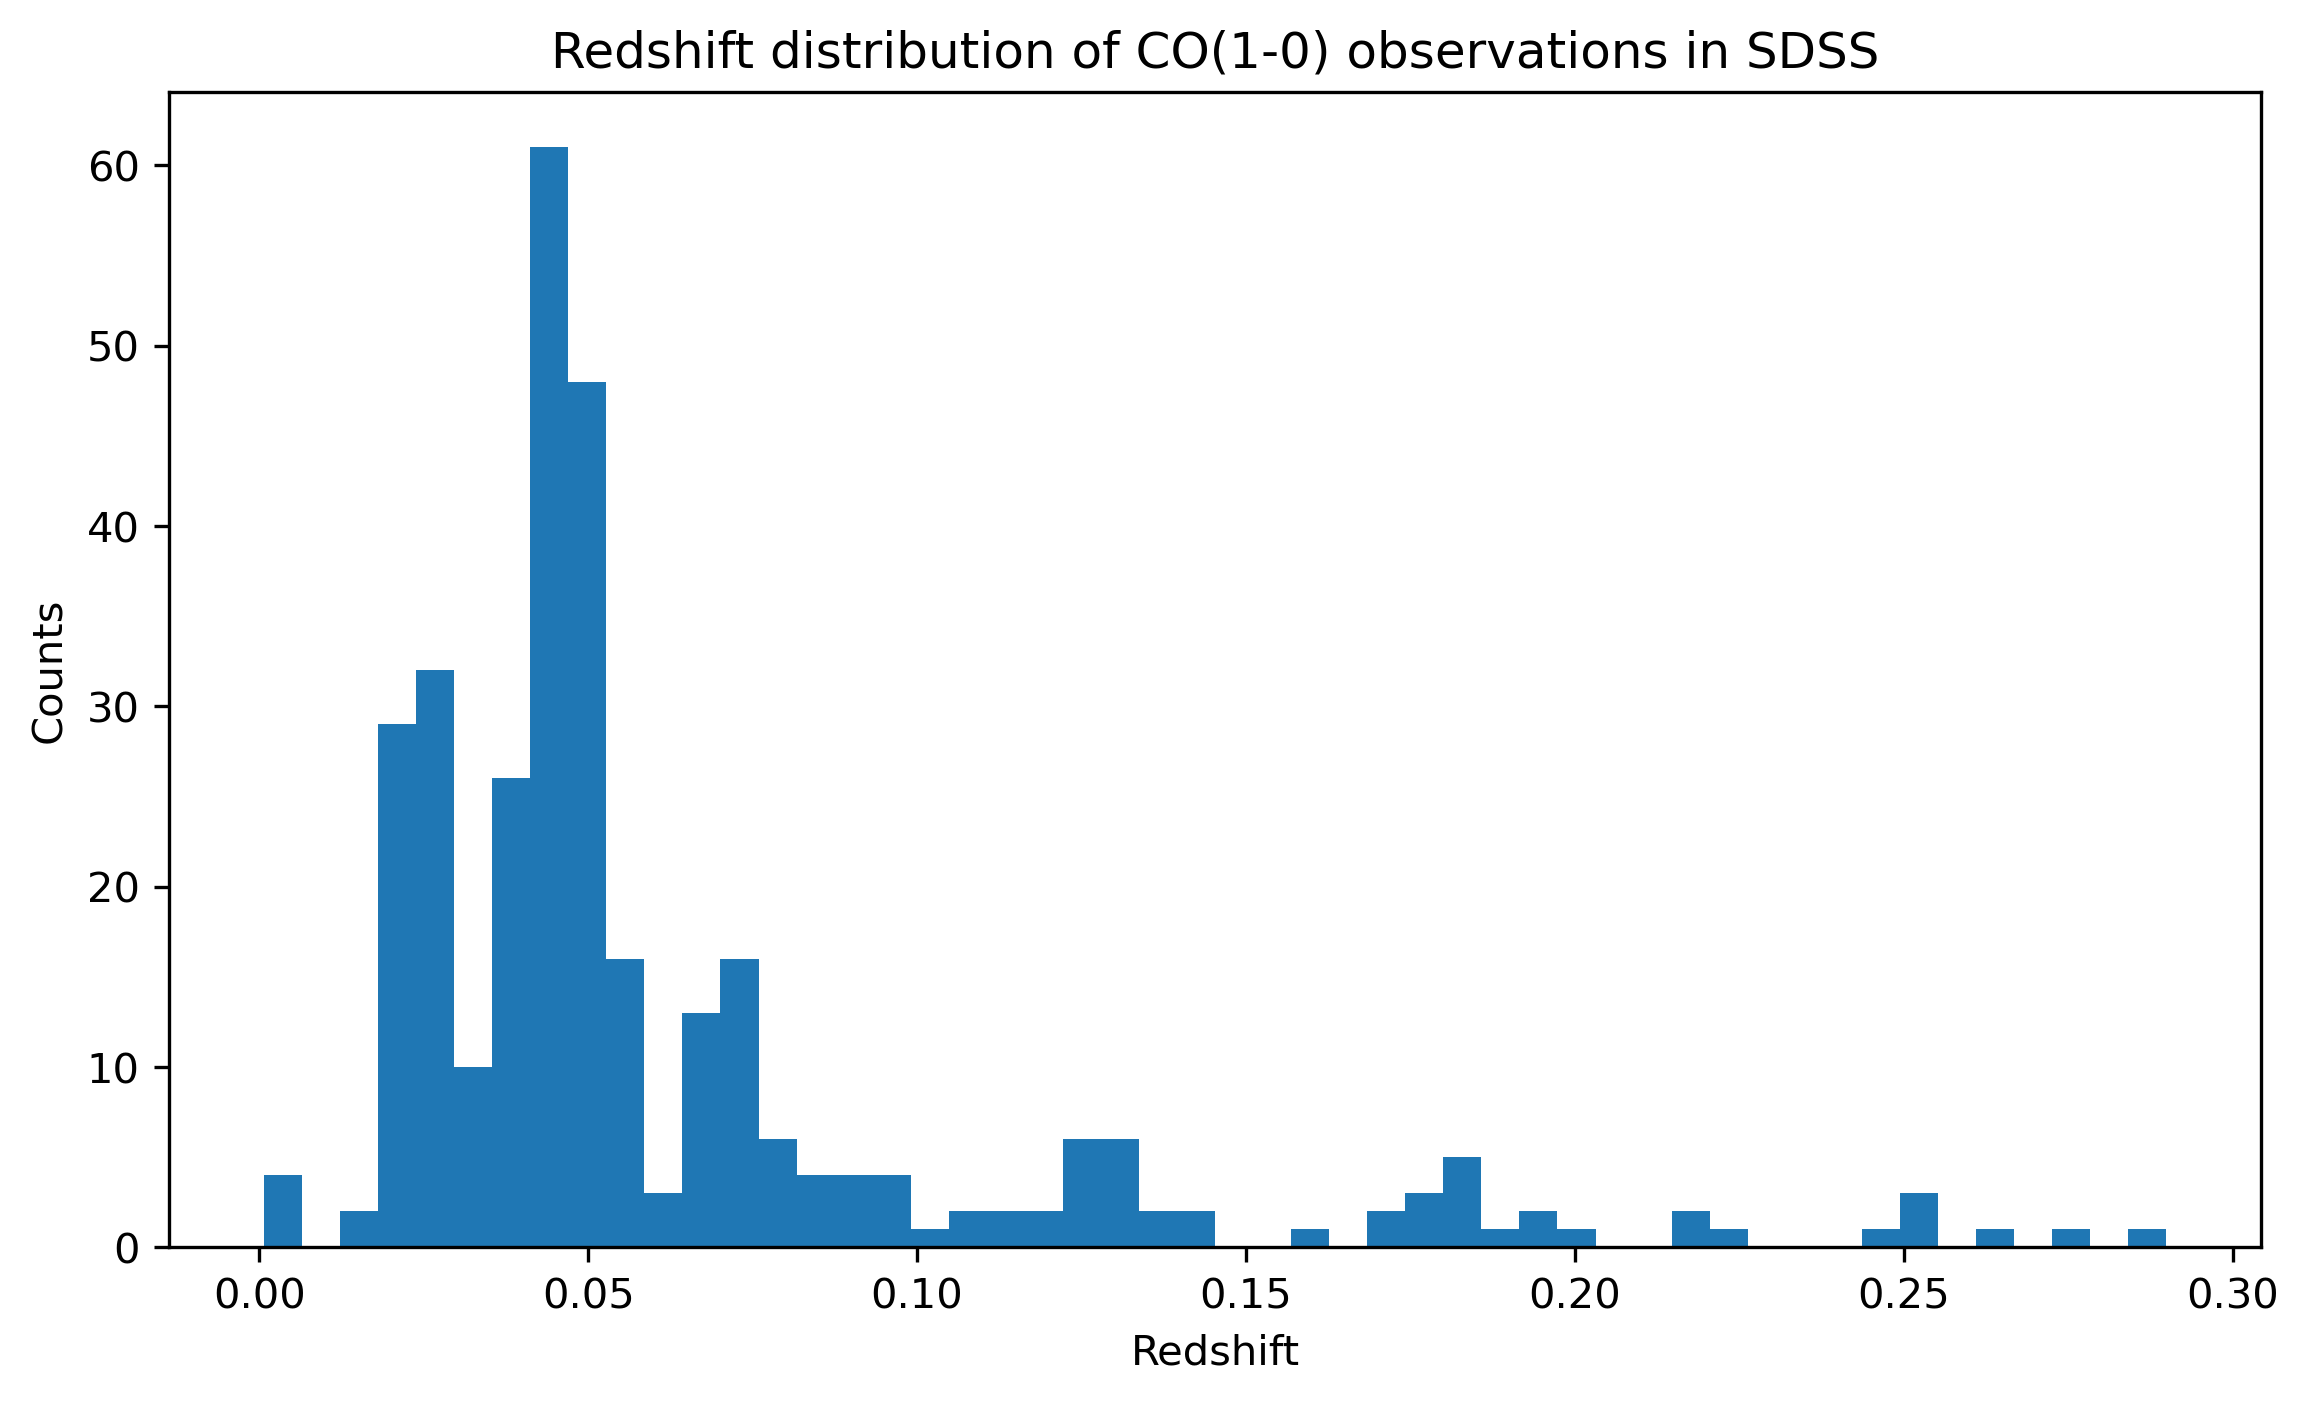

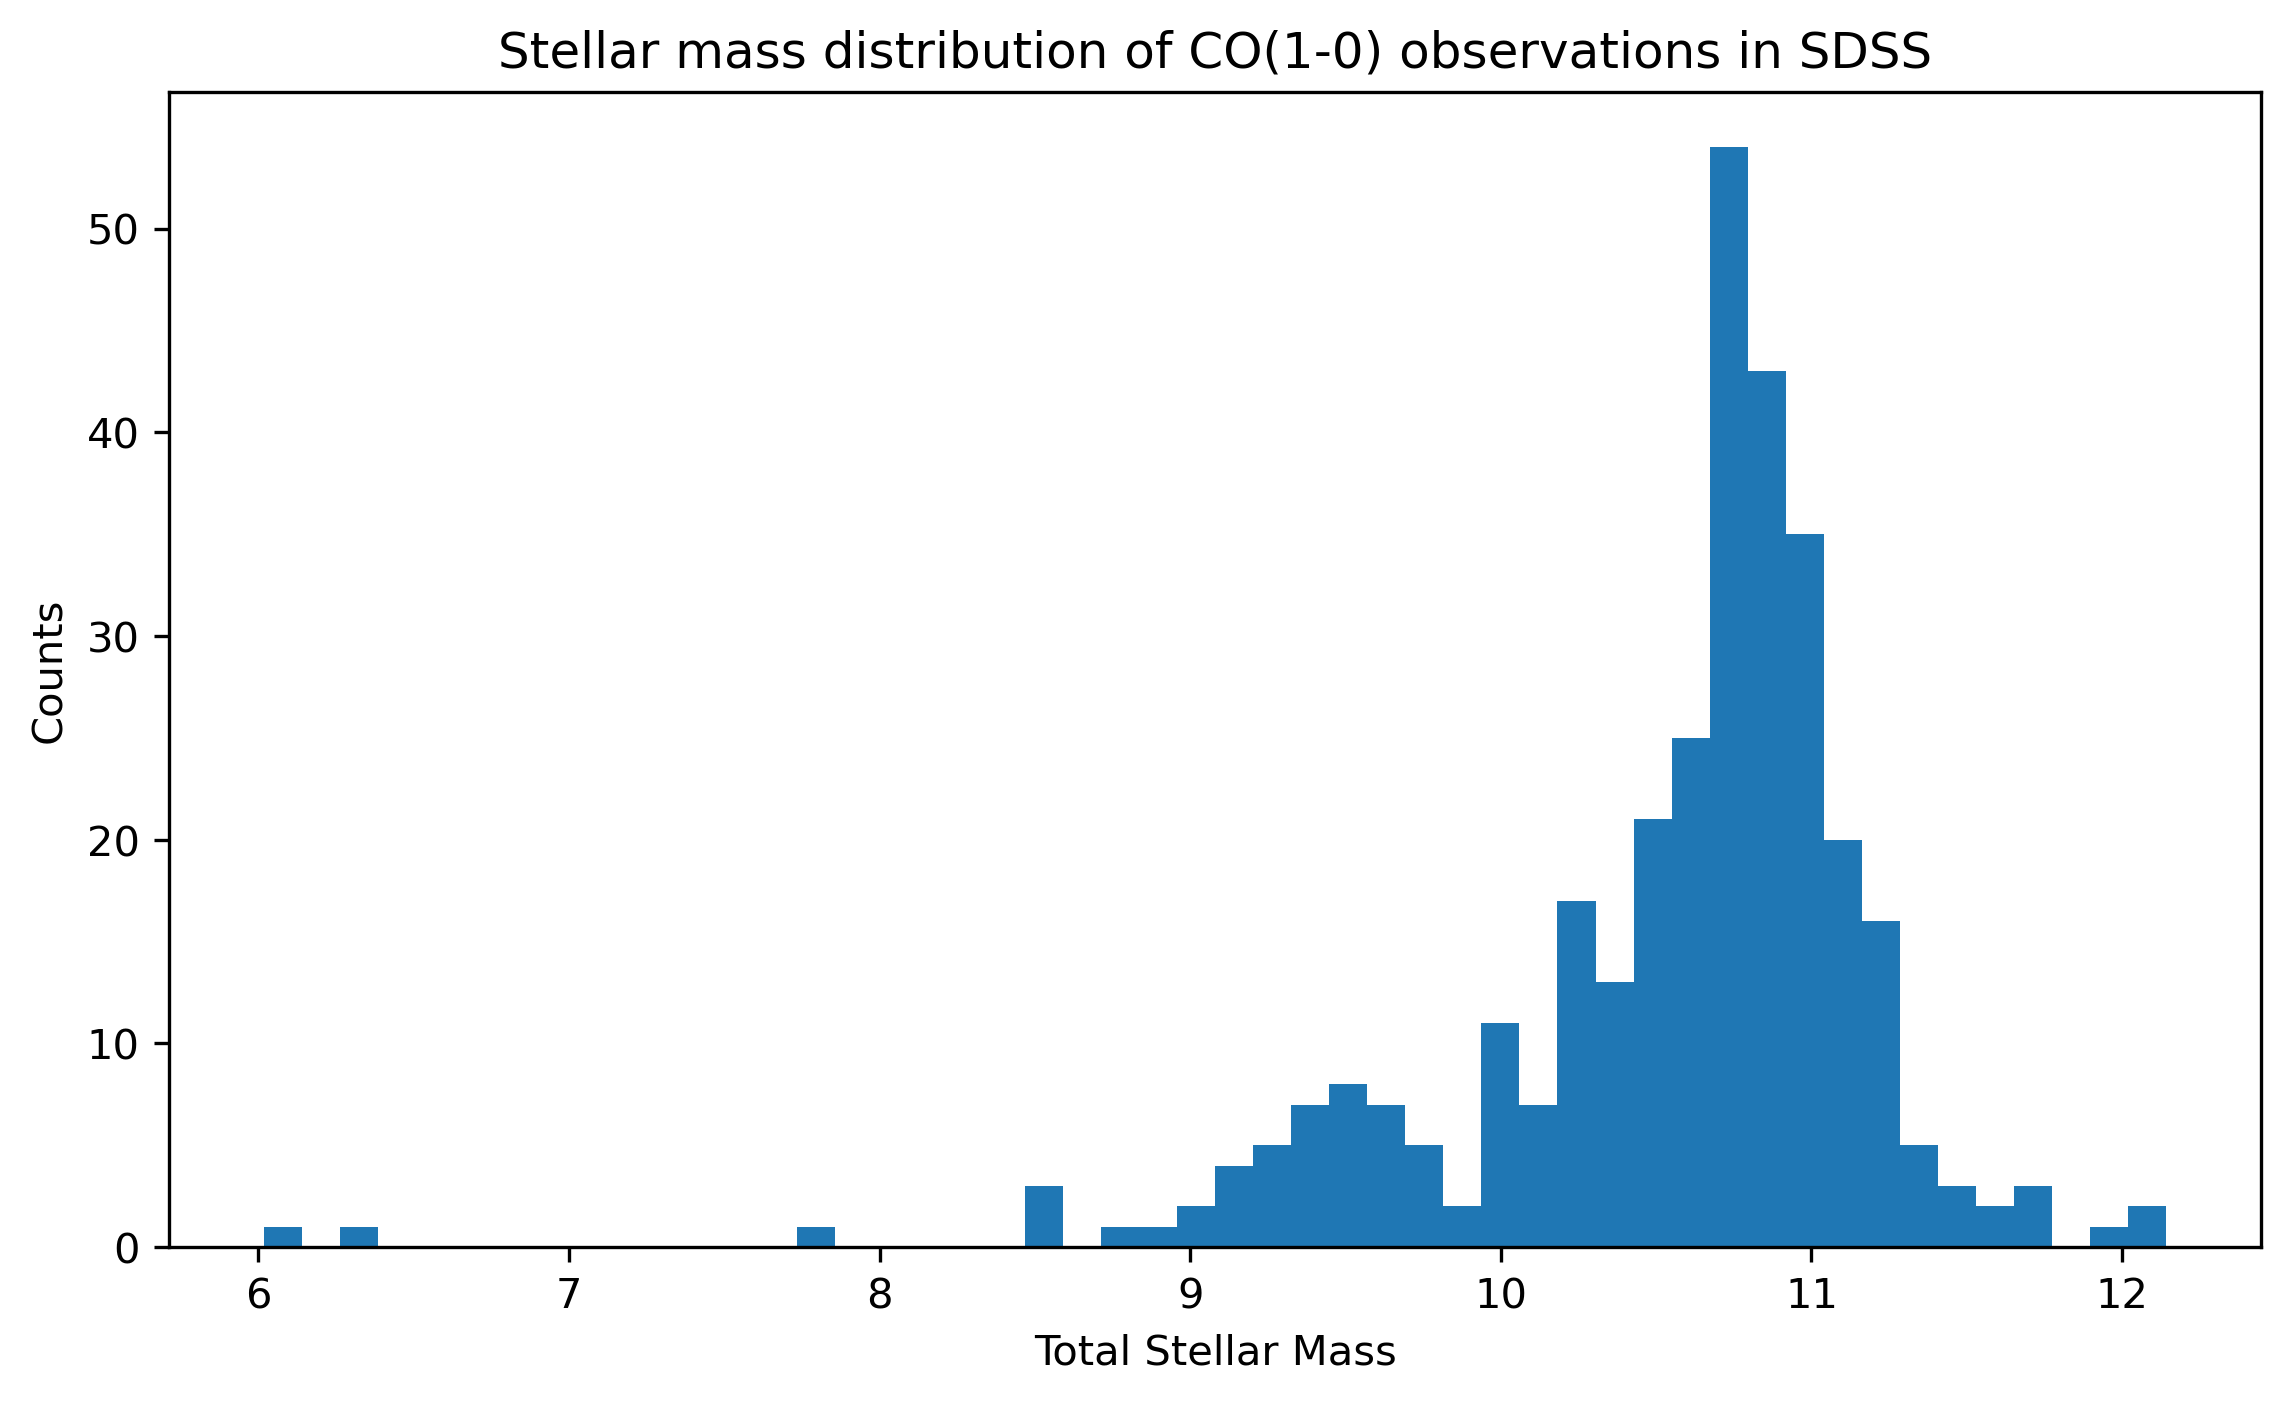

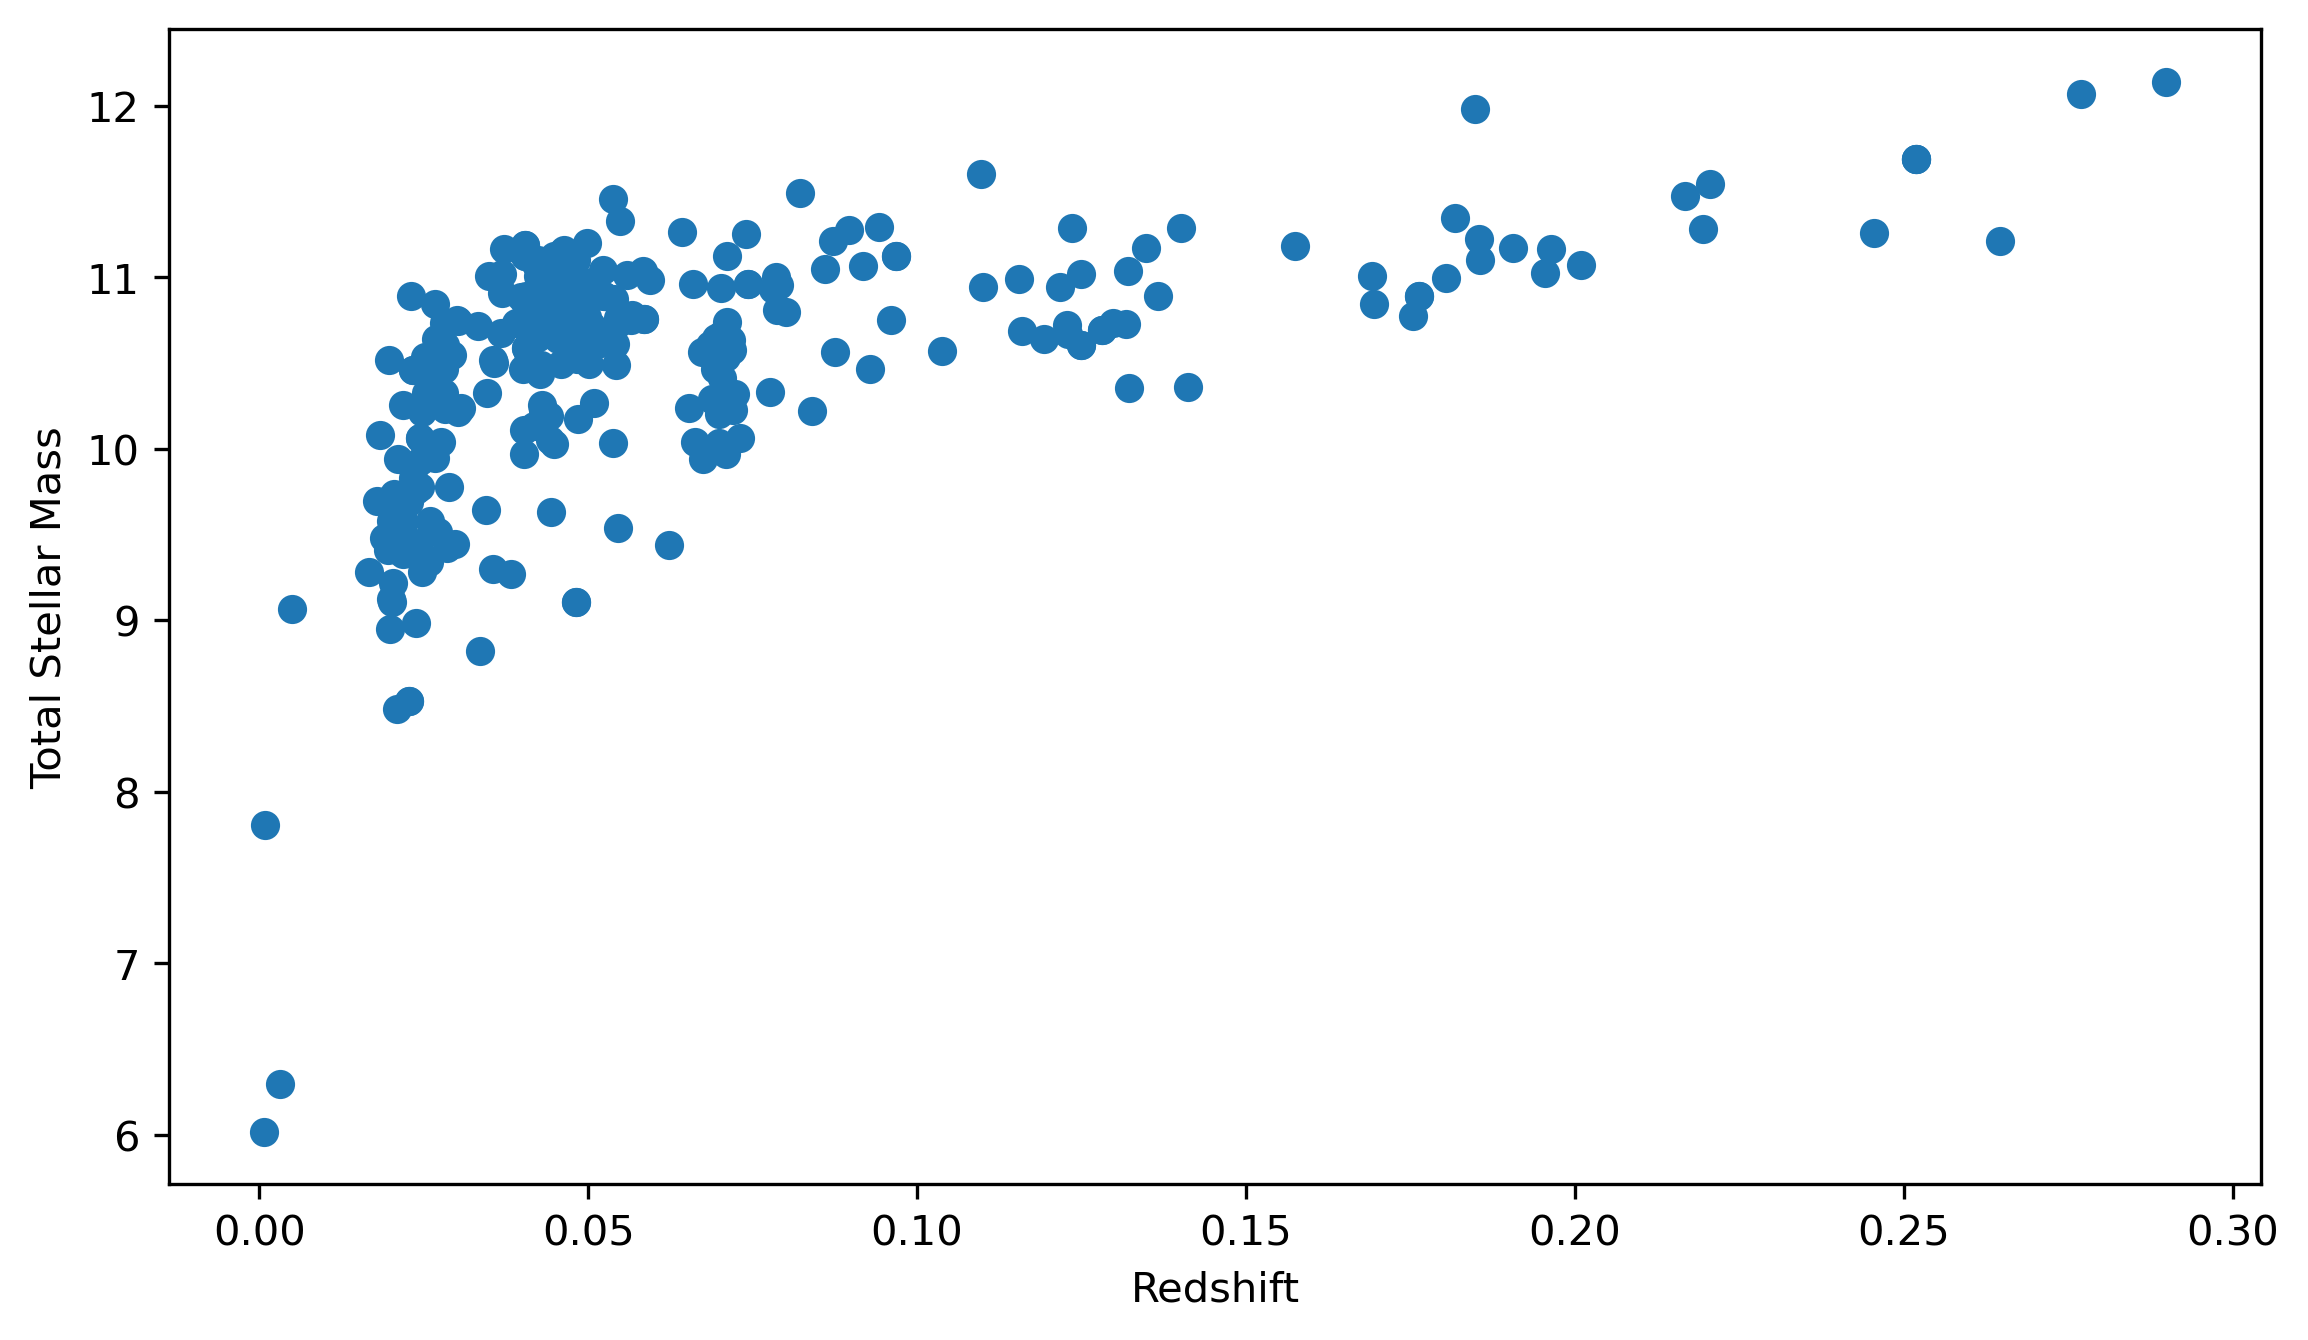

In [55]:
plt.figure(figsize = (9,5))
plt.hist(z_query[obs_mask[0]], bins = 50)
plt.title('Redshift distribution of CO(1-0) observations in SDSS')
plt.xlabel('Redshift')
plt.ylabel('Counts')
plt.show()

plt.figure(figsize = (9,5))
plt.hist(mass_query[obs_mask[0]], bins = 50)
plt.title('Stellar mass distribution of CO(1-0) observations in SDSS')
plt.xlabel('Total Stellar Mass')
plt.ylabel('Counts')
plt.show()

plt.figure(figsize = (9,5))
plt.scatter(z_query[obs_mask[0]], mass_query[obs_mask[0]])
plt.ylabel('Total Stellar Mass')
plt.xlabel('Redshift')
plt.show()

## Output RA and Decs to file

In [56]:
rf_12CO_10 = 115.27120180 #GHz
redshifted_line = rf_12CO_10/(1+z_query)

obs_mask = [(myquery["min_freq_GHz"] < redshifted_line) & 
                   (myquery["max_freq_GHz"] > redshifted_line) & 
                   (myquery["ang_res_arcsec"] < 3) & 
                   (myquery["spatial_scale_max"] > 4*rpetro_query*0.396) & 
                   (myquery["dataproduct_type"] == 'cube')]

In [28]:
(myquery["min_freq_GHz"] < redshifted_line) & (myquery["max_freq_GHz"] > redshifted_line)

0     True
1    False
2    False
3    False
4    False
     ...  
3     True
4    False
5    False
6     True
7    False
Length: 10392, dtype: bool

In [29]:
len(ra_query)

10392

In [57]:
len(np.unique(objID_query))

661

In [61]:
outfile = open('alma_sdss_target_list.txt', 'w')
outfile.write('# Unique SDSS targets with ANY ALMA observation within a 10" search radius\n')
outfile.write('# Column 1: SDSS ObjID\n')
outfile.write('# Column 2: ALMA RA\n')
outfile.write('# Column 2: ALMA Dec\n')

for i in range(len(ra_query)): 
    
    outfile.write(f'{objID_query[i]} {ra_query[i]} {dec_query[i]}')
                  
outfile.close()

In [77]:
in_co10 = np.array((myquery["min_freq_GHz"] < redshifted_line) & (myquery["max_freq_GHz"] > redshifted_line))

In [71]:
angres = np.array(myquery["ang_res_arcsec"])
spatialmax = np.array(myquery["spatial_scale_max"])

In [78]:
outfile = open('alma_sdss_target_info.txt', 'w')
outfile.write('# All SDSS targets with ANY ALMA observation within a 10" search radius\n')
outfile.write('# Column 1: SDSS ObjID\n')
outfile.write('# Column 2: ALMA RA\n')
outfile.write('# Column 2: ALMA Dec\n')
outfile.write('# Column 3: SDSS z_spec\n')
outfile.write('# Column 4: ALMA ang_res_arcsec\n')
outfile.write('# Column 5: ALMA spatial_scale_max\n')
outfile.write('# Column 6: Does this spectral window cover CO(1-0)? Boolean \n')

for i in range(len(ra_query)):
    
    outfile.write(f'{objID_query[i]} {ra_query[i]} {dec_query[i]} {z_query[i]} {angres[i]} {spatialmax[i]} {in_co10[i]}')
                  
outfile.close()